# Classifying Text by Philosophical Inclination

### Problem Statement 

The team is working on a new wellness app called "Daily Mind Journal" where users are invited to write a short journal entry everyday. The app will then analyze the journal entry and provide a personalized message for the user based on the philosophical inclinations of the user's entry.

Therefore, a key component of the app is to **classify the user's philosophical inclinations based on the text entry**. In this early prototype, we attempt to classify the user's entry into only two philosophical inclinations - Buddhism or Stoicism. In the future, we will expand the app to include more philosophical inclinations.

To this end, the project deliverable is a classifier model that can distinguish philosophical inclinations solely based on text.

The trained model can then be deployed within the app as an initial model, to be improved over time with real user data after launch.


### Business Context 

The proliferation of wellness apps has been exacerbated by pandemic fatigue around the globe. [The New York Times](https://www.nytimes.com/2021/02/17/magazine/wellness-apps.html) reports that "_Mindfulness apps like Calm, Headspace, Fabulous, Rootd and Liberate all surged over the past year, downloaded by people in search of reprieve from the crushing anxiety of the virus."_

Pair this idea with the [findings](https://www.webmd.com/mental-health/mental-health-benefits-of-journaling#:~:text=Journaling%20is%20the%20act%20of,of%20improving%20your%20mental%20health.) that daily journaling has been shown to reduce anxiety, regulate emotions, and even benefit physical health. 

This sets the stage for a new app that can act as an interactive digital journal by returning a positive thought of the day based on the user's journal input. The [mechanism](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4760272/) of replacing usual forms of worry with positive stimuli has been effective in helping with Generalized Anxiety Disorder (GAD). 

We think that the approach of daily journaling and the interactivity of being returned a curated message forms a powerful and positive feedback mechanism to help users alleviate worries. 

Part of the approach hinges on accurately profiling the user's philosophical inclination, so the message returned is appropriate to the user's outlook on existence. 


# Imports

In [1]:
import pandas as pd
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# modelling and interpretation
from pycaret.classification import *
import shap

# nlp libraries
from nltk import regexp_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords


# 1. Data Collection

Ideally, the app team will have a series of journal entries labelled with each user's true philosophical inclinations. 

This is a challenge because the app has not been deployed and surveying for philosophical inclination is difficult; in some cases a respondent may not even be aware of his/her own inclinations.

The next best option is to derive a proxy for this data. The classifier will be trained on a large corpus of Reddit submissions from two active subreddits - "**r/Buddhism**" and "**r/Stoicism**". The text submissions to these subreddits act as a pre-labelled corpus for a NLP classification model. In this case, the labels are the subreddits in which the posts were originally submitted.

To better match the anticipated journal inputs which will be received by the app, some preprocessing steps are proposed later in this report to improve the usefulness of the proxy data. 

### 1.1 Importing the Reddit Data via Pushshift API

Data was pulled via the code written in [`data_retrieval.ipynb`](2_data_retrieval.ipynb). Design decisions have been made to make the data retrieval function as versatile as possible. This allows for code longevity and future expansion as the project continues.

In this notebook, the pulled data is imported directly from the cell below.

In [2]:
df_a = pd.read_csv('output/Buddhism_select.csv',
                   parse_dates=['readable_time']).drop(columns=['Unnamed: 0'])
df_b = pd.read_csv('output/Stoicism_select.csv',
                   parse_dates=['readable_time']).drop(columns=['Unnamed: 0'])


### 1.2 Controlling for zeitgeist

Since the data is not aligned to the same time frame, it is important to control for differences in time periods. Social media posts tend to reflect the sociocultural zeitgeist. Therefore, if the time frames are not aligned, the data might be skewed by any social media trends or patterns that occurred over a certain period which might be reflected in one subreddit dataset but not the other.

In [3]:
# controlling for the same time frame in both datasets
earliest_time = max(df_a.readable_time.min(), df_b.readable_time.min())
latest_time = min(df_a.readable_time.max(), df_b.readable_time.max())

print(f'Earliest time: {earliest_time}')
print(f'Latest time: {latest_time}')

Earliest time: 2021-07-06 18:48:28
Latest time: 2022-05-31 23:24:53


In [4]:
# limiting both datasets to the same time frame
df_a = df_a.set_index('readable_time')[latest_time:earliest_time].reset_index()
df_b = df_b.set_index('readable_time')[latest_time:earliest_time].reset_index()

# 2. Data Cleaning

Some posts contain hyperlinks which are removed with regex patterns.

In [5]:
def clean_hyperlinks(text):
    text = re.sub('\(https.+?\)', '', text)
    text = re.sub('\[https.+?\]', '', text)
    text = re.sub('(https.+?)(?:\s)', '', text)
    return text


Empty posts or posts removed or deleted by moderators/users are also filtered out.

In [6]:
# filtering posts with analyzable self text
def remove_empty_posts(df, selftext_missing_list=['[removed]', '', ' ', '[deleted]']):
    df = df[~df['selftext'].isin(selftext_missing_list)]
    df = df[~df['selftext'].isna()]
    return df


Additionally, a new column is created to concatenate the title text and body of the post because some posts have to be read with the context of the post title.

In [7]:
def clean_df(df):

    original_len = len(df)

    df['total_text'] = df['title'] + ' ' + df['selftext']

    df['total_text'] = df.loc[~df['total_text'].isna(), 'total_text'].apply(
        lambda x: clean_hyperlinks(x))

    # posts that were only hyperlinks will also be removed
    df = remove_empty_posts(df)

    df = df.drop_duplicates(subset=['total_text'])

    print(f'Removed {original_len - len(df)} posts')

    return df


In [8]:
df_a = clean_df(df_a)
df_b = clean_df(df_b)


Removed 8576 posts
Removed 859 posts


### 2.1 A note on class imbalance 

In the context of a classification problem, the dataset is actually imbalanced. For a fixed time period, there are more entries from "r/Buddhism" than "r/Stoicism". This imbalance can be handled with a variety of methods - which includes, _inter alia_, undersampling/oversampling, selection of appropriate scoring metrics, discrimination threshold selection, and model-specific weighting methods. 

However, in the context of developing this app - there is no best guess for the class proportions of the two philosophical inclinations across the real user base. That can only be ascertained after launching the app and collecting user data over time. Therefore, the Reddit data is sampled to balance the final merged dataset at a 50-50 ratio.


In [9]:
# Ensuring that the two datasets are the same length
min_length = min(len(df_a), len(df_b))
df_a = df_a.sample(min_length, random_state=42)
df_b = df_b.sample(min_length, random_state=42)


### 2.2 Finalizing the data

The final dataframe df_data is created from the two subreddit datasets. The baseline classifier accuracy for the model is thus 0.5.

In [10]:
df_data = pd.concat([df_a, df_b]).reset_index(drop=True)
print(f'Final dataframe df_data has {len(df_data)} posts')

# baseline accuracy
print(df_data['subreddit'].value_counts(normalize=True))

# store df_data as a csv file
if not os.path.exists('output'):
    os.makedirs('output')
df_data.to_csv('output/subreddit_merged.csv')


Final dataframe df_data has 14400 posts
Buddhism    0.5
Stoicism    0.5
Name: subreddit, dtype: float64


# 3. EDA and Feature Engineering

Approximately a year of data was collected from the two subreddits from **2021-07-06 18:48:28** to **2022-05-31 23:24:53**.

Missing values were already handled in data cleaning and finalization. This section is dedicated to EDA and feature engineering.


### 3.2 Understanding subreddit activity

In [11]:
nunique_stoicism = df_data.loc[df_data['subreddit']=='Stoicism', 'author'].nunique()
nunique_buddhism = df_data.loc[df_data['subreddit']=='Buddhism', 'author'].nunique()

print(f'r/Buddhism has {nunique_buddhism} unique authors')
print(f'r/Stoicism has {nunique_stoicism} unique authors')

r/Buddhism has 3819 unique authors
r/Stoicism has 4550 unique authors


r/Buddhism text posts are contributed by a smaller pool of unique authors. r/Buddhism is also the more active subreddit when measured by text posts per day.

From **2021-07-06 18:48:28** to **2022-05-31 23:24:53**

| Metric             | r/Buddhism | r/Stoicism |
|--------------------|------------|------------|
| Total Members      | 621k       | 461k       |
| Unique Authors*    | 3819       | 4550       |
| Text posts per day | 30.07      | 21.23      |

**For texts posts within the time frame*



### 3.3 Differences in verbosity

Three new features are engineered to study differences in word counts, text length, and average length of words for each text post.

In [14]:
df_data['text_length'] = df_data['total_text'].str.len()
df_data['word_count'] = df_data['total_text'].str.split(' ').str.len()
df_data['vocab_length'] = df_data['text_length']/df_data['word_count']


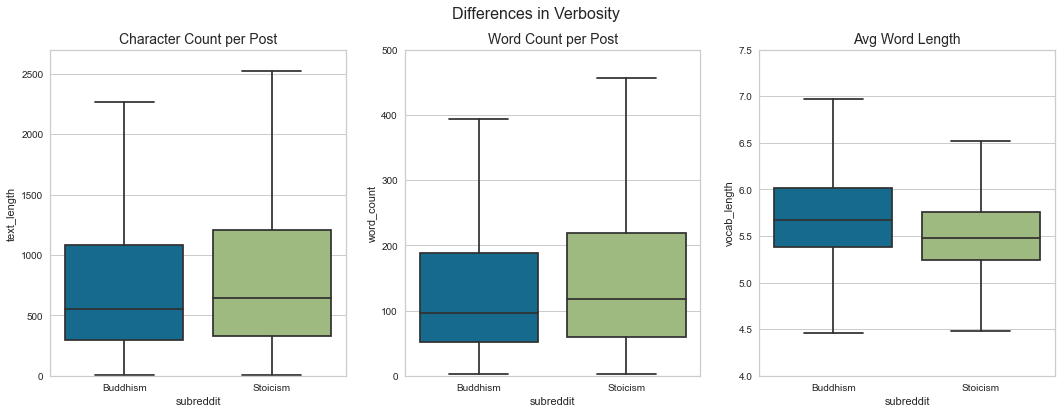

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

fig.suptitle('Differences in Verbosity\n', fontsize=16)

ax[0].set_title('Character Count per Post', fontsize=14)
ax[1].set_title('Word Count per Post', fontsize=14)
ax[2].set_title('Avg Word Length', fontsize=14)

sns.boxplot(x='subreddit', y='text_length', data=df_data, ax=ax[0], fliersize=0).set(ylim=(0, 2700))
sns.boxplot(x='subreddit', y='word_count', data=df_data, ax=ax[1], fliersize=0).set(ylim=(0, 500))
sns.boxplot(x='subreddit', y='vocab_length', data=df_data, ax=ax[2], fliersize=0).set(ylim=(4, 7.5));


**Notes on verbosity**

Posts on r/Stoicism are marginally longer in terms of character counts and words counts. However, the average word length in a r/Buddhism posts is longer.

These patterns in verbosity should not be taken at face value as social media post length can easily be skewed if the user group has a tendency to use certain quotes, names, and phrases.

It is possible that some of these patterns in verbosity can help the model classify journal entries on the app, i.e. a entry with Stoic inclinations might be longer. These three features are added to the classification model so feature importance can be ascertained through the modelling.

_As a disclosure the outliers have been omitted from the above visualizations. Outliers omitted from the chart are data points located outside the whiskers of the box plot. In other words outside 1.5 times the interquartile range above the upper quartile and below the lower quartile (Q1 - 1.5 * IQR or Q3 + 1.5 * IQR))_

### 3.4 Difference in vocabulary

This [NLP paper](https://www.ischool.berkeley.edu/sites/default/files/sproject_attachments/nlp_sentiment_in_fiction.pdf) studies relationships between pronoun usage, sentiment and cultural trends. 

Since this is an exercise in teasing out philosophical inclinations from text, the use and frequency of certain pronouns can provide the model with additional information to make a classification. 

An additional 6 features are engineered using regex patterns. These are counting specific pattern occurrences within a post:
- individual pronouns
- communal pronouns
- second person pronouns
- third person pronouns
- impersonal pronouns
- question statements

In [16]:
# search for individual pronouns including typos
individualRegex = re.compile(r'\b(i|ive|im|me|mine|myself)\b')

# search for communal pronouns including typos
communalRegex = re.compile(r'\b(us|we|weve|ours|our|ourselves)\b')

# search for second person pronouns
secondPersonRegex = re.compile(r'\b(you|your|yours|yourself|yourselves)\b')

# search for third person pronouns
thirdPersonRegex = re.compile(
    r'\b(he|him|his|himself|she|her|hers|herself|they|them|their|theirs|themselves)\b')

# search for impersonal pronouns
impersonalRegex = re.compile(r'\b(it|its|itself)\b')

# search for questions
questionRegex = re.compile(r'(?:\s[A-Za-z\s]*)(\?)')


In [17]:
df_data['individual_pronouns_count'] = df_data['total_text'].apply(
    lambda x: len(individualRegex.findall(x.lower())))

df_data['communal_pronouns_count'] = df_data['total_text'].apply(
    lambda x: len(communalRegex.findall(x.lower())))

df_data['second_pronouns_count'] = df_data['total_text'].apply(
    lambda x: len(secondPersonRegex.findall(x.lower())))

df_data['third_pronouns_count'] = df_data['total_text'].apply(
    lambda x: len(thirdPersonRegex.findall(x.lower())))

df_data['impersonal_pronouns_count'] = df_data['total_text'].apply(
    lambda x: len(impersonalRegex.findall(x.lower())))

df_data['questions_count'] = df_data['total_text'].apply(
    lambda x: len(questionRegex.findall(x.lower())))


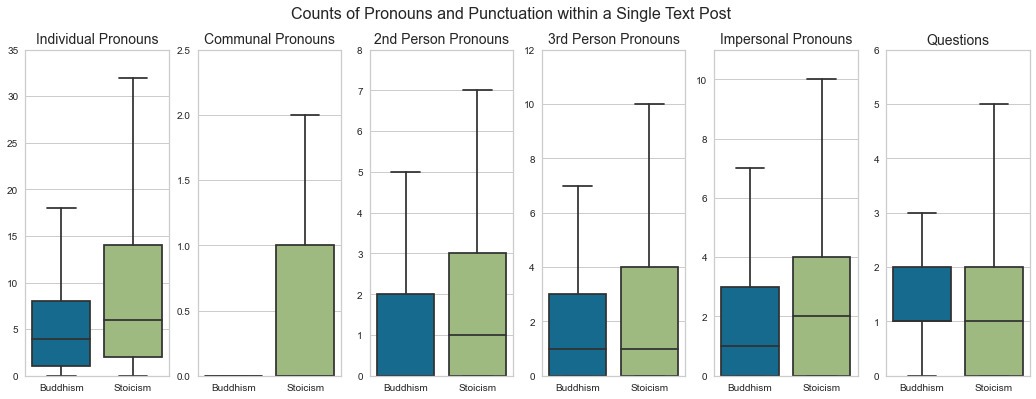

In [18]:
# plotting the boxplots for the new features
fig, ax = plt.subplots(1, 6, figsize=(18, 6))

fig.suptitle(
    'Counts of Pronouns and Punctuation within a Single Text Post\n', fontsize=16)

ax[0].set_title('Individual Pronouns', fontsize=14)
ax[1].set_title('Communal Pronouns', fontsize=14)
ax[2].set_title('2nd Person Pronouns', fontsize=14)
ax[3].set_title('3rd Person Pronouns', fontsize=14)
ax[4].set_title('Impersonal Pronouns', fontsize=14)
ax[5].set_title('Questions', fontsize=14)

for i in range(6):
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)

sns.boxplot(x='subreddit', y='individual_pronouns_count',
            data=df_data, ax=ax[0], fliersize=0).set(ylim=(0, 35))
sns.boxplot(x='subreddit', y='communal_pronouns_count',
            data=df_data, ax=ax[1], fliersize=0).set(ylim=(0, 2.5))
sns.boxplot(x='subreddit', y='second_pronouns_count',
            data=df_data, ax=ax[2], fliersize=0).set(ylim=(0, 8))
sns.boxplot(x='subreddit', y='third_pronouns_count',
            data=df_data, ax=ax[3], fliersize=0).set(ylim=(0, 12))
sns.boxplot(x='subreddit', y='impersonal_pronouns_count',
            data=df_data, ax=ax[4], fliersize=0).set(ylim=(0, 11))
sns.boxplot(x='subreddit', y='questions_count', data=df_data,
            ax=ax[5], fliersize=0).set(ylim=(0, 6))


**Notes on Vocabulary**

Note that text on r/Stoicism already tends to be longer as explored in the previous section. There is always an option to normalize these counts by post length but the count form is retained because these 6 new features will also be added to the model alongside the features that measure verbosity. 

Overall, pronoun use is more common in posts from r/Stoicism. However, the most glaring difference is that posts on r/Buddhism rarely use communal pronouns like **"us|we|weve|ours|our|ourselves"**. This can be a useful distinguishing factor in helping to classify text with a certain philosophical slant. 

The use of question statements is also relatively similar between groups, with approximately one question statement on average per post. This point should be noted as it shows that the text corpus is heavily weighted towards posts that are questions or contain questions. It reveals a limitation in the training data because the anticipated input data on the app would be in a journaling context and it is unlikely that a user will write rhetorical questions in such a situation. 

_As a disclosure the outliers have been omitted from the above visualizations. Outliers omitted from the chart are data points located outside the whiskers of the box plot. In other words outside 1.5 times the interquartile range above the upper quartile and below the lower quartile (Q1 - 1.5 * IQR or Q3 + 1.5 * IQR))_

# 4. Data Preprocessing

The EDA has provided some explanatory analysis on subreddit activity, text verbosity, use of pronouns, and the frequency of question statements. 

Additionally, 9 new features have been engineered from the text only, which can be fed into a classification model. 

### 4.1 Mapping the response and renaming columns

The target variable is mapped to 'Buddhism': 0, 'Stoicism': 1

The columns are also renamed with a "_" suffix because text vectorization methods will be applied to the text. This renaming prevents name collisions downstream during data manipulation.

In [19]:
# mapping response to 0 and 1
df_data['subreddit'] = df_data['subreddit'].map({'Buddhism': 0, 'Stoicism': 1})

# rename columns with ending underscores to avoid name collisions when vectorizers are used
df_data.columns = [col_name+'_' for col_name in list(df_data.columns)]
df_data.columns


Index(['readable_time_', 'subreddit_', 'id_', 'author_', 'title_', 'selftext_',
       'total_text_', 'text_length_', 'word_count_', 'vocab_length_',
       'individual_pronouns_count_', 'communal_pronouns_count_',
       'second_pronouns_count_', 'third_pronouns_count_',
       'impersonal_pronouns_count_', 'questions_count_'],
      dtype='object')

### 4.2 Preprocessing - Removing stop words, tokenizing, lemmatizing, stemming

A stop words list is used prior to lemmatizing or stemming. The standard [NLTK 'English'](https://gist.github.com/sebleier/554280) stop words list is used. Additionally, the most common words in the corpus are screened to identify additional stop words (code omitted for brevity).

The idea of these additional stop words are words that could easily be used to classify the post but are **unlikely to be used in a user's journal entry**. It is unlikely that a journal entry will contain words like "buddhism" or "marcus aurelius" unless the user is already a keen practitioner of such philosophies. 

If these are not removed then the model may overfit to this corpus and be unable to generalize to the actual app data, which is likely to be devoid of these additional stop words. 


In [20]:
stop_words = stopwords.words('english')

additional_stop_words = ['stoic',
                         'stoics',
                         'stoicism',
                         'buddhism',
                         'buddhist',
                         'buddhists',
                         'buddha',
                         'marcus',
                         'aurelius',
                         'seneca',
                         'epictetus',
                         'dharma',
                         'bodhisattva',
                         'sutra',
                         'monk',
                         'karma']

stop_words = stop_words + additional_stop_words

print(stop_words)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

These custom tokenizers can be called within CountVectorizer and TfidfVectorizer as tokenizer arguments. They have some specific purposes:
- Remove stop words from the text
- Tokenize the text with a regular expression. \w+ matches one or more word characters
- Lemmatize or stem the text

In [21]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in regexp_tokenize(doc, pattern=r'\w+')
                if t not in stop_words]

class StemTokenizer:
    def __init__(self):
        self.p_stemmer = PorterStemmer()

    def __call__(self, doc):
        return [self.p_stemmer.stem(t) for t in regexp_tokenize(doc, pattern=r'\w+') 
                if t not in stop_words]

### 4.3 Preparing train and test data

In [22]:
# train test split
y = df_data['subreddit_']
X = df_data.drop(columns=['readable_time_', 'subreddit_', 'id_',
                          'author_', 'title_', 'selftext_'])

# default is to shuffle the dataset - stated here explicitly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=101, shuffle=True)


In [23]:
# preprocessing the total_text data with the custom vectorizer
vect = TfidfVectorizer(max_features=1500,
                       ngram_range=[1, 2], tokenizer=StemTokenizer())

# fit transform the training data
features = vect.fit_transform(X_train['total_text_'])
features_df = pd.DataFrame(
    features.toarray(), columns=vect.get_feature_names())
X_train = pd.concat([X_train.reset_index(drop=True), features_df], axis=1)

# only transform the test data using the same vectorizer
features = vect.transform(X_test['total_text_'])
features_df = pd.DataFrame(
    features.toarray(), columns=vect.get_feature_names())
X_test = pd.concat([X_test.reset_index(drop=True), features_df], axis=1)


In [24]:
# piecing X and y data back together to fit Pycaret's input format
train_data = pd.concat([y_train.reset_index(), X_train], axis=1)
test_data = pd.concat([y_test.reset_index(), X_test], axis=1)

# fixing column names to avoid name collisions
train_data.columns = ['index_'] + list(train_data.columns[1:])
test_data.columns = ['index_'] + list(test_data.columns[1:])


# 5. Modelling

### 5.1 Rapid prototyping of classifier models with Pycaret

PyCaret is an open-source machine learning library in Python that automates machine learning workflows. This allows for a variety of models to be tested before a final model is selected.

In [25]:
numerical_features = list(train_data.columns)[3:]
ignore_features = ['index_', 'total_text_']

# session id is the random state
temp = setup(data=train_data, target='subreddit_',
             ignore_features=ignore_features,
             numeric_features=numerical_features, use_gpu=True, n_jobs=-1, 
             silent=True, session_id=101, remove_perfect_collinearity=False)


,Description,Value
0,session_id,101
1,Target,subreddit_
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(11520, 1512)"
5,Missing Values,False
6,Numeric Features,1509
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
# catboost ommitted as training time was too long and performance was found to be poor 
best_model = compare_models(exclude=['catboost'])


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8484,0.9266,0.8753,0.8319,0.8530,0.6968,0.6980,2.7210
et,Extra Trees Classifier,0.8443,0.9124,0.8936,0.8147,0.8521,0.6886,0.6923,5.5990
lr,Logistic Regression,0.8440,0.9174,0.8649,0.8314,0.8478,0.6879,0.6886,16.3160
xgboost,Extreme Gradient Boosting,0.8385,0.9205,0.8635,0.8239,0.8430,0.6770,0.6781,2.2960
ridge,Ridge Classifier,0.8349,0.0000,0.8612,0.8196,0.8398,0.6697,0.6708,0.2600
lda,Linear Discriminant Analysis,0.8194,0.8980,0.8388,0.8094,0.8236,0.6388,0.6395,5.3490
rf,Random Forest Classifier,0.8186,0.8975,0.8499,0.8011,0.8247,0.6370,0.6384,3.0960
gbc,Gradient Boosting Classifier,0.8081,0.8921,0.8323,0.7954,0.8133,0.6162,0.6171,22.2700
nb,Naive Bayes,0.8057,0.8851,0.9000,0.7584,0.8231,0.6110,0.6223,0.2380
ada,Ada Boost Classifier,0.7977,0.8831,0.8247,0.7839,0.8036,0.5953,0.5964,5.0520


### 5.2 Choosing a model 

For this specific business case, the models are evaluated on three criteria:

1. Accuracy - Measured by the number of correct prediction over the total number of predictions. The dataset is balanced so this metric is suitable. The table above provides stratified cross-validated metrics for each model, along with training times.

2. Training Time - If deployed as an app, the model will need to be retrained on a daily or weekly basis. Training time is a limited business resource and must be considered, especially as the size of the dataset grows.

3. [Probabilistic classification](https://en.wikipedia.org/wiki/Probabilistic_classification) -  _"a probabilistic classifier is a classifier that is able to predict, given an observation of an input, a probability distribution over a set of classes, rather than only outputting the most likely class that the observation should belong to."_ 

Probabilistic classification is an advantage in the this case because it allows for the discrimination threshold to be shifted on the fly. This gives the app team the flexibility to calibrate the discrimination threshold and tweak the final classification - without explicitly retraining the model. This means that in particular situations and for certain user profiles, the discrimination threshold can be tweaked to better match the actual inclinations without costly model retraining. 

Blackbox models are also viable because model interpretability and inference are not required by the end customer. However, the workings must still be explainable to the app development team and key decision makers. 

The final model selected is the **Light Gradient Boosting Machine (lightGBM)** classifier. This model operates on the idea of gradient boosting - which is to sequentially apply a weak decision tree algorithm to repeatedly modified versions of the data, thereby producing a sequence of decision trees. The overall prediction is then obtained from the final "forest" of trees. 

LightGBM has the best score on accuracy and training time is relatively fast compared to other methods. It is also a probabilistic classifier model.

***Note on feature scaling**

*Features were not scaled in this final iteration of the notebook. However, LightGBM and other tree-based models have no requirement for feature scaling. Additionally, no assumption of feature independence is required (Note: Inference may be hampered by such interaction effects but prediction is unaffected.)*

In [27]:
model = create_model('lightgbm')
print(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8575,0.9290,0.8840,0.8404,0.8616,0.7149,0.7159
1,0.8451,0.9235,0.8840,0.8211,0.8514,0.6901,0.6922
2,0.8612,0.9331,0.8938,0.8399,0.8660,0.7224,0.7239
3,0.8350,0.9078,0.8469,0.8285,0.8376,0.6699,0.6701
4,0.8598,0.9349,0.9037,0.8318,0.8663,0.7195,0.7222
5,0.8536,0.9410,0.8765,0.8392,0.8575,0.7071,0.7078
6,0.8474,0.9266,0.8543,0.8439,0.8491,0.6948,0.6948
7,0.8536,0.9318,0.8741,0.8409,0.8571,0.7071,0.7077
8,0.8238,0.9081,0.8617,0.8023,0.8310,0.6475,0.6493


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=101, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


### 5.3 Automated hyperparameter tuning with Optuna

LightGBM is a GBDT algorithm which has a number of hyperparameters for tuning. This workflow leverages [Optuna](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258), which is an automatic hyperparameter optimization framework that is conveniently integrated within Pycaret.

The default hyperparameter search is optimizing for accuracy. 

Tuning has resulted in a dip in accuracy but is within the expected range of the standard deviation of the accuracy scores. It may also result in better performance on the test data.


In [28]:
tuned_model = tune_model(model, search_library = 'optuna')
print(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8389,0.9205,0.8395,0.8395,0.8395,0.6778,0.6778
1,0.8290,0.9110,0.8593,0.8112,0.8345,0.6579,0.6591
2,0.8538,0.9241,0.8642,0.8475,0.8557,0.7075,0.7077
3,0.8114,0.9000,0.8000,0.8203,0.8100,0.6229,0.6231
4,0.8511,0.9220,0.8691,0.8401,0.8544,0.7022,0.7026
5,0.8313,0.9266,0.8519,0.8195,0.8354,0.6625,0.6630
6,0.8437,0.9150,0.8370,0.8496,0.8433,0.6874,0.6874
7,0.8337,0.9214,0.8395,0.8313,0.8354,0.6675,0.6675
8,0.8015,0.8929,0.8173,0.7938,0.8054,0.6029,0.6032


LGBMClassifier(bagging_fraction=0.47054685581679645, bagging_freq=0,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', feature_fraction=0.5947647978625222,
               importance_type='split', learning_rate=0.10030990964985954,
               max_depth=-1, min_child_samples=64, min_child_weight=0.001,
               min_split_gain=0.4781674167895694, n_estimators=286, n_jobs=-1,
               num_leaves=114, objective=None, random_state=101,
               reg_alpha=1.1811709714001726e-05,
               reg_lambda=0.0010237156466975537, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


# 6. Model Evaluation

The lightGBM model exceeds the baseline accuracy score (0.5) with an accuracy of 0.83.

Given a Reddit post (stripped of obvious key words), the model is able to accurately classify 83% of posts to its originating subreddit. 


### 6.1 Performance on unseen data

The model is used to predict on the test data and a confusion matrix is created. Accuracy on the test data is acceptable and does not suggest that any overfitting has occurred.

In [29]:
test_pred = predict_model(tuned_model, data=X_test)
from pycaret.utils import check_metric
check_metric(test_pred['Label'], y_test, metric = 'Accuracy')

0.8354

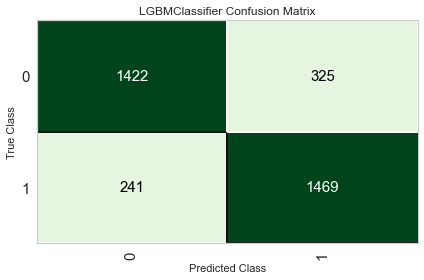

In [30]:
plot_model(tuned_model, plot = 'confusion_matrix')

### 6.2 Local feature importance

LightGBM is a common blackbox model. It is not possible to interpret how the features affect the model output without additional frameworks. Therefore, [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) can be used to derive feature importance for a particular observation (**local feature importance**) and also for the entire test dataset (**global feature importance**).

To explain this idea, two Shapley force plots are presented as examples of local feature importance.

In [31]:
# to control any versioning as two specific observations need to be highlighted for discussion
test_data = pd.read_csv('output/test_data.csv')

explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer(test_data.drop(columns=['index_','subreddit_', 'total_text_']))

In [32]:
def plot_shap(ref_index):
    # displaying the full text at the index
    print('Subreddit Text:')
    print(test_data.loc[test_data['index_'] == ref_index, 'total_text_'].item())
    print('')

    y_pred = tuned_model.predict(test_data[test_data['index_'] == ref_index]
                                .drop(columns=['index_', 'subreddit_', 'total_text_'])
                                )[0]

    if y_pred == 0:
        print(f'Model Prediction = {y_pred}: from r/Buddhism')
    elif y_pred == 1:
        print(f'Model Prediction = {y_pred}: from r/Stoicism')

    y_actual = (test_data
                .loc[test_data['index_'] == ref_index, 'subreddit_']
                .item()
                )

    if y_actual == 0:
        print(f'Actual Class = {y_actual}: text is really from r/Buddhism')
    elif y_actual == 1:
        print(f'Actual Class = {y_actual}: text is really from r/Stoicism')

    shap.initjs()

    shap_index = test_data.index[test_data['index_'] == ref_index][0]

    return shap.force_plot(explainer.expected_value[1],
                    shap_values.values[shap_index][:, 1],
                    test_data.drop(
                        columns=['index_', 'subreddit_', 'total_text_']).iloc[shap_index]
                    )    

In [41]:
plot_shap(3566)

Subreddit Text:
This Concept of Oneness is an empty cliche This concept of Oneness has been imposed on us by Spiritual Teachers for Centuries. It doesn't bear any resemblance to our actual experience in daily life. Any effort to achieve Oneness creates suffering. The Buddha taught all concepts created by the mind are Empty. This includes Oneness.

Model Prediction = 0: from r/Buddhism
Actual Class = 0: text is really from r/Buddhism


In [40]:
plot_shap(9468)

Subreddit Text:
Self improving has caused suffering in my life How do I stop striving and reaching to be better all the time it exhausting. It’s like how do I stop trying so hard to change. How do I be at peace with myself and just not give a fuck about what others think. But how do I not alway myself to sparrow down a dark hole because lack of discipline. How do I stop thinking if become this person I’ll be at peace and that I’ll be happy. I feel like self improvement is making me suffer.

Model Prediction = 1: from r/Stoicism
Actual Class = 1: text is really from r/Stoicism


**Interpreting the SHAP Force plot for local feature importance**

- Values on the axis, including the base value, are mapped to the model output. In this case, the lightGBM classifier is predicting the probability of the post originating from r/Stoicism. Hence, the model prediction values are not 0 and 1, but floats pending an additional transformation function. 

- The base value is the average of all output values of the model from the training data. 

- The individual red/blue segments represent how much those features influence the final output of the model for a particular observation. 

- Intuitively features in red are influencing the outcome towards the right, i.e. the post is more likely to be from r/Stoicism. Features in blue are influencing the outcome towards the left, i.e. the post is more likely to be from r/Buddhism.

- Also consider the first plot, where the model correctly predicted that the post was from r/Buddhism. It was able to make this prediction without using obvious keywords like "Buddha" or "Buddhist" in the post. These words were removed prior to the model being trained so that the model is able to pick up on more subtle features, and have better performance on journal type entries.


### 6.3 Global feature importance

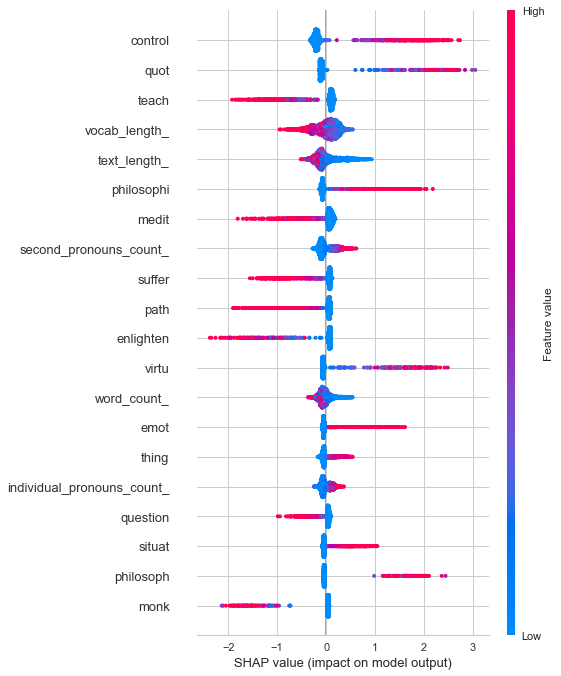

In [35]:
interpret_model(tuned_model, plot = 'summary')

**Interpreting global feature importance**

- Shapley values for every feature and every observation are computed. The features are then sorted by the sum of Shapley value magnitudes over all observations, with the top 20 features depicted here. 

- The color represents the feature value (red high, blue low).

- For example, the feature "control" is actually a tf-idf transformed count of the number of times the word "control" occurs in the text. The feature is thus a numerical float with high and low values. High values (red) have higher Shapley values according to this model and tilt the model output towards a higher probability of belonging to r/Stoicism. 

- High tf-idf for words such as "control, quote, philosophy, virtue, emotion, situation" and a more frequent use of second-person pronouns, all lead to higher predicted probabilities of belonging to r/Stoicism.

- On the other hand, high tf-idf for words like "teach, meditate, suffer, path, enlighten, question" and use of longer vocabulary in general, all lead to higher predicted probabilities of belonging to r/Buddhism.

# 7. Conclusion

The project deliverable is a trained lightGBM classifier, which can be deployed on the app after some refinements. The classifier delivers a respectable classification accuracy of 0.83 on a balanced dataset and is able to discern the originating subreddit of a post simply by using the text within the post. 

The model has two strengths over similar approaches:

1. For the purpose of reducing variance on real app data, the model is trained on the modified corpus where obvious keywords words are omitted. This is to avoid the model overfitting to the obvious keywords words present in Reddit posts but **unlikely to be used in a user's journal entry**. 

2. The model leverages new features engineered from the original text (measures of verbosity, pronoun usage, and frequency of question statements). Such data is not always used in a NLP pre-processing workflow and are sometimes missed out entirely due to stop word removal.

Indeed these strengths have led to a model that significantly outperforms the baseline. Additionally, with the use of Shapley values, feature importance can also be extracted for model explainability.

### 7.1 Limitations 

1. Most glaringly, the training data may not be representative of the journal entries on the app. Reddit posts have a different tone, objective, and vocabulary from what might be written in a private journal. For example, posts on both subreddits have a high frequency of question statements, which is something that is not usually observed in a journal reflection. 

2. Biases in data collection are definitely present. The model is trained on a modified corpus of Reddit posts. According to [sources](https://www.statista.com/statistics/325144/reddit-global-active-user-distribution/#:~:text=Reddit%20use%20in%20the%20United,platform%20strongly%20declines%20with%20age.), users from the USA account for almost 47.1% of the traffic on the site, with most users between the age of 18-49 and predominantly male. This can have significant effects on overall text patterns on the site leading to the model being unable to effectively generalize on the actual app user base. 

3. Lack of a feedback loop. In this early prototype, the model does not have capabilities to learn from misclassifications. 

4. Possible poor performance on translated text and other languages. The model is trained on the text written on Reddit with mostly native English speakers.

### 7.2 Possible extensions

1. More data can be collected through other social media sources like blogs, twitter, or facebook for model training. However, these sources do not come with the convenience of clear labels. Perhaps hashtags could serve that purpose for other media sources.

2. Transformer deep learning models have had great success in NLP tasks and are more likely to identify patterns in syntax, semantics, and structure. Some of these patterns could be effective in identifying philosophical inclination from text. 

# 8. Annex - Model Deployment

A WIP model deployment is stored in ['predict.ipynb'](3_predict.ipynb) where users are free to experiment with the model.